In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from IPython.display import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
import itertools
warnings.filterwarnings("ignore")
np.random.seed(1)

## Problem 1

In [157]:
import numpy as np
np.random.seed(1)
p = 10
n = 100
beta = np.array([0, 1, 1, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0])
X_train = np.random.normal(0, 5, size=(n, p))
X_test = np.random.normal(0, 5, size=(n, p))
epsilon_train = np.random.normal(0, 1, size=n)
epsilon_test = np.random.normal(0, 1, size=n)
y_train = beta[0] + np.dot(X_train, beta[1:]) + epsilon_train
y_test = beta[0] + np.dot(X_test, beta[1:]) + epsilon_test

In [158]:
X_train_df =pd.DataFrame(X_train, columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10'])
y_train_df = pd.DataFrame(y_train, columns = ['Y'])
X_test_df =pd.DataFrame(X_test, columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10'])
y_test_df = pd.DataFrame(y_test, columns = ['Y'])


## a.) BEST SUBSET SELECTION 

In [7]:
def bic_calculation(n, RSS,k):
    bic = n * np.log(RSS/n) + k * np.log(n)
    return bic

In [8]:
def best_subset(X, Y):
    models_best = pd.DataFrame(columns=["RSS", "model",'Features', "BIC"])
    for i in range(1,len(X.columns)+1):
        results = []
        best_RSS = np.inf
        best_model = 0
        best_bic = np.inf
        best_predictor = []
        for combo in itertools.combinations(X.columns, i):
            model = LinearRegression().fit(X[list(combo)],Y)
            RSS = ((model.predict(X[list(combo)]) - Y) ** 2).sum()[0]
            bic = bic_calculation(X.shape[0],RSS,i)
            if bic < best_bic :
                best_model = model
                best_predictor = combo
                best_bic = bic
                best_RSS = RSS
        models_best.loc[i,'RSS'] = best_RSS
        models_best.loc[i,'model'] = best_model
        models_best.loc[i,'BIC'] = best_bic
        models_best.loc[i,'Features'] = best_predictor
    return models_best

In [9]:
models = best_subset(X_train_df, y_train_df)
best_features = models[models.BIC == models.BIC.min()].reset_index()['Features'][0]
best_bic = models[models.BIC == models.BIC.min()].reset_index()['BIC'][0]
print("Best Model Features :", best_features, "\nBIC : ",best_bic)
models

Best Model Features : ('X1', 'X2', 'X3') 
BIC :  1.2134103604775905


,RSS,model,Features,BIC
1,2196.897808,LinearRegression(),"(X2,)",313.568307
2,126.856336,LinearRegression(),"(X1, X2)",32.998845
3,88.159633,LinearRegression(),"(X1, X2, X3)",1.21341
4,85.639751,LinearRegression(),"(X1, X2, X3, X4)",2.918618
5,83.425313,LinearRegression(),"(X1, X2, X3, X4, X10)",4.90401
6,81.823827,LinearRegression(),"(X1, X2, X3, X4, X5, X10)",7.570851
7,81.346619,LinearRegression(),"(X1, X2, X3, X4, X5, X9, X10)",11.5911
8,81.07959,LinearRegression(),"(X1, X2, X3, X4, X5, X8, X9, X10)",15.86747
9,80.846478,LinearRegression(),"(X1, X2, X3, X4, X5, X7, X8, X9, X10)",20.184715
10,80.63034,LinearRegression(),"(X1, X2, X3, X4, X5, X6, X7, X8, X9, X10)",24.522184


In [10]:
best_model = models[models.BIC == models.BIC.min()].reset_index()['model'][0]
print('Coefficients for Best Model')
best_model.coef_

Coefficients for Best Model


array([[0.98120121, 0.98634042, 0.12030284]])

In [11]:
y_pred = best_model.predict(X_test_df[list(best_features)])
test_error = mean_squared_error(y_test_df, y_pred)
test_error

0.9491847872079198

### The predictors selected by the Best Subset Selection are X1, X2 and X3. The value of the coefficients is also very close to the true statistical model coefficients of 1,1 and 0.1.  The best subset selection selects the three variables with the highest coefficients in the true model and hence the code is functioning well and it deems the other predictors to be insignificant. The run time for Best Subset was higher than Forward Selection as it tries more combinations.

## b.) FORWARD SELECTION

In [12]:
def forward_selection(X,Y):
    combo = pd.DataFrame(columns=["Features","RSS","BIC","Model"])
    predictors = []
    for i in range(1,len(X.columns)+1):
        remaining_predictors = [p for p in X.columns if p not in predictors]
        results = []
        best_RSS = np.inf
        best_model = 0
        best_bic = np.inf
        best_predictor = []
        for p in remaining_predictors:
            check = list(predictors+[p])
            model = LinearRegression().fit(X[check],Y)
            RSS = ((model.predict(X[check]) - Y) ** 2).sum()[0]
            bic = bic_calculation(X.shape[0],RSS,i)
            #RSS = ((model.predict(X[check]) - Y) ** 2).sum()
            if bic < best_bic :
                best_model = model
                best_predictor = p
                best_RSS = RSS
                best_bic = bic
        predictors.append(best_predictor)
        #print(RSS)
        combo.loc[i,'BIC'] = best_bic
        combo.loc[i,'RSS'] = best_RSS 
        combo.loc[i,'Features'] = list(predictors)
        combo.loc[i,'Model'] = best_model
    return combo

In [13]:
combo = forward_selection(X_train_df, y_train_df)
best_features_fwd = combo[combo.BIC == combo.BIC.min()].reset_index()['Features'][0]
best_bic_fwd = combo[combo.BIC == combo.BIC.min()].reset_index()['BIC'][0]
print("Best Model Features :", best_features_fwd, "\nBIC : ", best_bic_fwd)
combo

Best Model Features : ['X2', 'X1', 'X3'] 
BIC :  1.2134103604775763


,Features,RSS,BIC,Model
1,[X2],2196.897808,313.568307,LinearRegression()
2,"[X2, X1]",126.856336,32.998845,LinearRegression()
3,"[X2, X1, X3]",88.159633,1.21341,LinearRegression()
4,"[X2, X1, X3, X4]",85.639751,2.918618,LinearRegression()
5,"[X2, X1, X3, X4, X10]",83.425313,4.90401,LinearRegression()
6,"[X2, X1, X3, X4, X10, X5]",81.823827,7.570851,LinearRegression()
7,"[X2, X1, X3, X4, X10, X5, X9]",81.346619,11.5911,LinearRegression()
8,"[X2, X1, X3, X4, X10, X5, X9, X8]",81.07959,15.86747,LinearRegression()
9,"[X2, X1, X3, X4, X10, X5, X9, X8, X7]",80.846478,20.184715,LinearRegression()
10,"[X2, X1, X3, X4, X10, X5, X9, X8, X7, X6]",80.63034,24.522184,LinearRegression()


In [14]:
best_model_fwd = combo[combo.BIC == combo.BIC.min()].reset_index()['Model'][0]
print('Coefficients for Best Model')
best_model_fwd.coef_

Coefficients for Best Model


array([[0.98634042, 0.98120121, 0.12030284]])

In [15]:
y_pred = best_model_fwd.predict(X_test_df[list(best_features)])
test_error = mean_squared_error(y_test_df, y_pred)
test_error

0.9529450500128962

### The predictors selected by the Forward Selection are X1, X2 and X3. The value of the coefficients is also very close to the true statistical model coefficients of 1,1 and 0.1. The Forward selection also selects the three variables with the highest coefficients in the true model and hence the code is functioning well and it deems the other predictors to be insignificant.

## c.) LASSO 

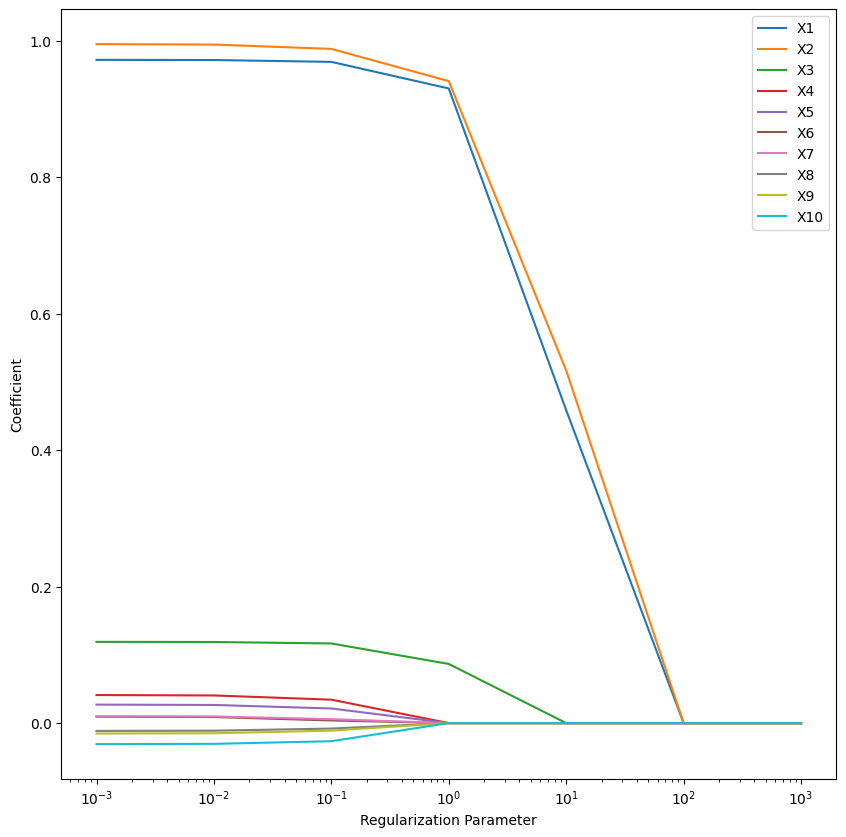

In [164]:
lambdas = [1000,100,10,1,0.1,0.01,0.001]
coefs = []
for l in lambdas:
    lasso = Lasso(alpha=l, fit_intercept=True)
    lasso.fit(X_train_df, y_train_df)
    coefs.append(lasso.coef_)
plt.figure(figsize=(10, 10))
plt.plot(lambdas, coefs)
plt.xscale('log')
plt.xlabel('Regularization Parameter')
plt.ylabel('Coefficient')
plt.legend([f'X{i}' for i in range(1,11)])
plt.show()


In [165]:
mse = []
lambdas = [100,10,1,0.1,0.01,0.001]
best_bic = np.inf
best_lambda = 0
best_model = None
combination = pd.DataFrame(columns=["lambda","BIC","Model"])
for i in lambdas :
    lasso = Lasso(alpha=i)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_train_df)
    #print(X_train_df)
    y_pred_lasso = y_pred_lasso.reshape(-1,1)
    RSS = ((y_pred_lasso - y_train_df) ** 2).sum()[0]
    bic = bic_calculation(X_train_df.shape[0],RSS,i)
    combination.loc[i,'lambda'] = i
    combination.loc[i,'BIC'] = bic
    combination.loc[i,'Model'] = lasso
    if bic< best_bic:
        best_bic = bic
        best_lambda = i
        best_model = lasso
combination

,lambda,BIC,Model
100.000,100,830.477582,Lasso(alpha=100)
10.000,10,288.648413,Lasso(alpha=10)
1.000,1,5.833073,Lasso(alpha=1)
0.100,0.1,-20.487166,Lasso(alpha=0.1)
0.010,0.01,-21.477641,Lasso(alpha=0.01)
0.001,0.001,-21.524855,Lasso(alpha=0.001)


In [73]:
best_model.coef_

array([ 0.97179081,  0.99482258,  0.11903474,  0.04109983,  0.02707404,
        0.00935846,  0.01012217, -0.01144416, -0.01527265, -0.03082243])

In [74]:
best_bic

-21.52485493628854

In [75]:
best_lambda

0.001

In [76]:
y_pred_lasso = best_model.predict(X_test_df)
test_error = mean_squared_error(y_test_df, y_pred_lasso)
test_error

0.9813507057597984

### Lasso Regression also outputs the results where the coefficients for X1, X2 and X3 have the coefficients which aligns with the true statistical model and are significant. The lambda value selected using BIC is 0.001. The test error is higher for Lasso than the best subset and forward selection as it penalizes for high value of coefficients so as to prevent overfitting. It also pushes the rest of the variables to close to or almost zero rather than close to their true value which is one of the key aspects of lasso regularization as it helps in feature selection by reducing the coefficient of non significant predictors.

## d.) RIDGE

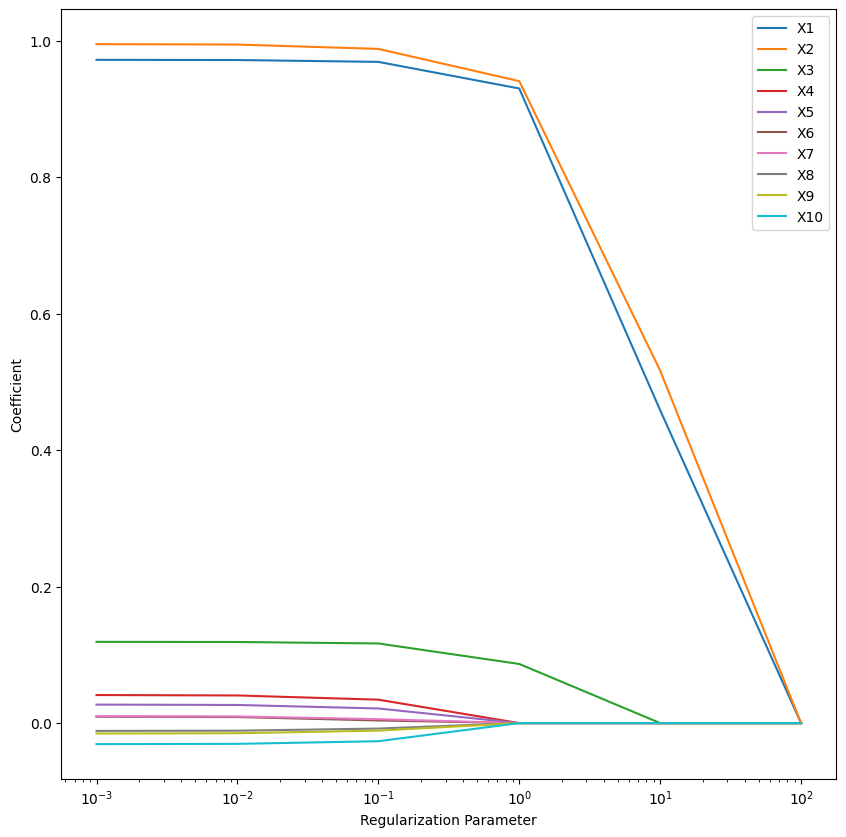

In [173]:
lambdas = [100,10,1,0.1,0.01,0.001]
ridge_coefs = []
for i in lambdas:
    ridge = Ridge(alpha= i, fit_intercept=True)
    ridge.fit(X_train_df, y_train_df)
    ridge_coefs.append(ridge.coef_)
plt.figure(figsize=(10, 10))
plt.plot(lambdas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Regularization Parameter')
plt.ylabel('Coefficient')
plt.legend([f'X{i}' for i in range(1,11)])
plt.show()

In [77]:
mse = []
lambdas = [100,10,1,0.1,0.01,0.001]
best_bic = np.inf
best_lambda = 0
best_model = None
combination = pd.DataFrame(columns=["lambda","BIC","Model"])
for i in lambdas :
    ridge = Ridge(alpha=i)
    ridge.fit(X_train_df, y_train_df)
    y_pred_ridge = ridge.predict(X_train_df)
    RSS = ((y_pred_ridge - y_train_df) ** 2).sum()[0]
    bic = bic_calculation(X_train_df.shape[0],RSS,i)
    combination.loc[i,'lambda'] = i
    combination.loc[i,'BIC'] = bic
    combination.loc[i,'Model'] = lasso
    if bic< best_bic:
        best_bic = bic
        best_lambda = i
        best_model = ridge
combination

,lambda,BIC,Model
100.000,100,450.029355,Lasso(alpha=0.001)
10.000,10,24.651209,Lasso(alpha=0.001)
1.000,1,-16.923043,Lasso(alpha=0.001)
0.100,0.1,-21.068987,Lasso(alpha=0.001)
0.010,0.01,-21.483466,Lasso(alpha=0.001)
0.001,0.001,-21.524912,Lasso(alpha=0.001)


In [78]:
best_model.coef_

array([[ 0.9718137 ,  0.99488754,  0.11906108,  0.04116985,  0.02713213,
         0.00941436,  0.01016473, -0.01147976, -0.01531669, -0.03086694]])

In [79]:
best_bic

-21.524912340532193

In [80]:
best_lambda

0.001

In [81]:
y_pred_lasso = best_model.predict(X_test_df)
test_error = mean_squared_error(y_test_df, y_pred_lasso)
test_error

0.9816944666521469

### Ridge Regression also leads to similar results where the coefficients for X1, X2 and X3 have the value for the coefficient whichaligns with the true statistical model and is significant. The lambda value selected using BIC is 0.001. The test error is again higher for Ridge as was seen in Lasso than the best subset and forward selection method as it penalizes for high value of coefficients so as to prevent overfitting. It also reduces the coefficients of non significant predictors and not necessarily close to their true value

## e.) COMPARISON

In [84]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())
X_test = sm.add_constant(X_test)
y_test_pred = results.predict(X_test)
test_error = np.mean((y_test - y_test_pred)**2)
print('Test error:', test_error)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     437.4
Date:                Mon, 15 May 2023   Prob (F-statistic):           4.11e-71
Time:                        21:47:57   Log-Likelihood:                -131.13
No. Observations:                 100   AIC:                             284.3
Df Residuals:                      89   BIC:                             312.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0463      0.099     -0.466      0.6

###  All Methods are able to select the most significant variables in their own unique way. Forward Selection and Best Subset Selection opt for the three variables that are most important and have the lowest test error. The value for other coefficients also remain close to their true statistical values.  In case of Lasso and Ridge regularization, the models for the three important predictors, i.e X1, X2 and X3 are close to their true values but the other coefficients are pushed closer to 0. The test error in case of Lasso and Ridge is higher than in case of Best Subset and Forward Selection as they include a cost for the coefficients so as to prevent overfitting.

## Problem 2

## a.)

In [119]:
mean = np.ones(10) * 10
cov = np.ones((10, 10)) * 0.95
np.fill_diagonal(cov, 1)
X_train = np.random.multivariate_normal(mean, cov, size=100)
eps = np.random.normal(0, 0.001, size=100)
y_train = X_train[:,0] + eps
X_test = np.random.multivariate_normal(mean, cov, size=100)
eps = np.random.normal(0, 0.001, size=100)
y_test = X_test[:,0] + eps
lambdas = [.001, .01, .1, 1, 10, 100, 1000]

## Lasso

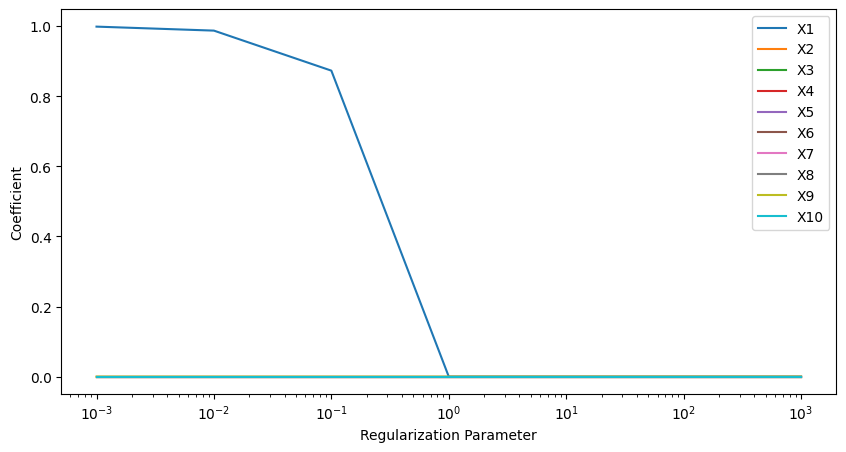

In [120]:
coefs = []
for i in lambdas:
    model = Lasso(alpha=i)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)
    
plt.figure(figsize=(10, 5))
plt.plot(lambdas, coefs)
plt.xscale('log')
plt.xlabel('Regularization Parameter')
plt.ylabel('Coefficient')
plt.legend([f'X{i}' for i in range(1,11)])
plt.show()

In [121]:
params = {'alpha': lambdas}
grid = GridSearchCV(Lasso(), params, cv=5)
grid.fit(X_train, y_train)
best_alpha_lasso = grid.best_params_['alpha']
print("Lasso:", best_alpha_lasso)
model = Lasso(alpha=best_alpha_lasso)
model.fit(X_train, y_train)
lasso_y_pred = model.predict(X_test)
lasso_mse_error = mean_squared_error(y_test, lasso_y_pred)
print("Lasso MSE:", lasso_mse_error)


Lasso: 0.001
Lasso MSE: 3.3200043106900986e-06


## Ridge

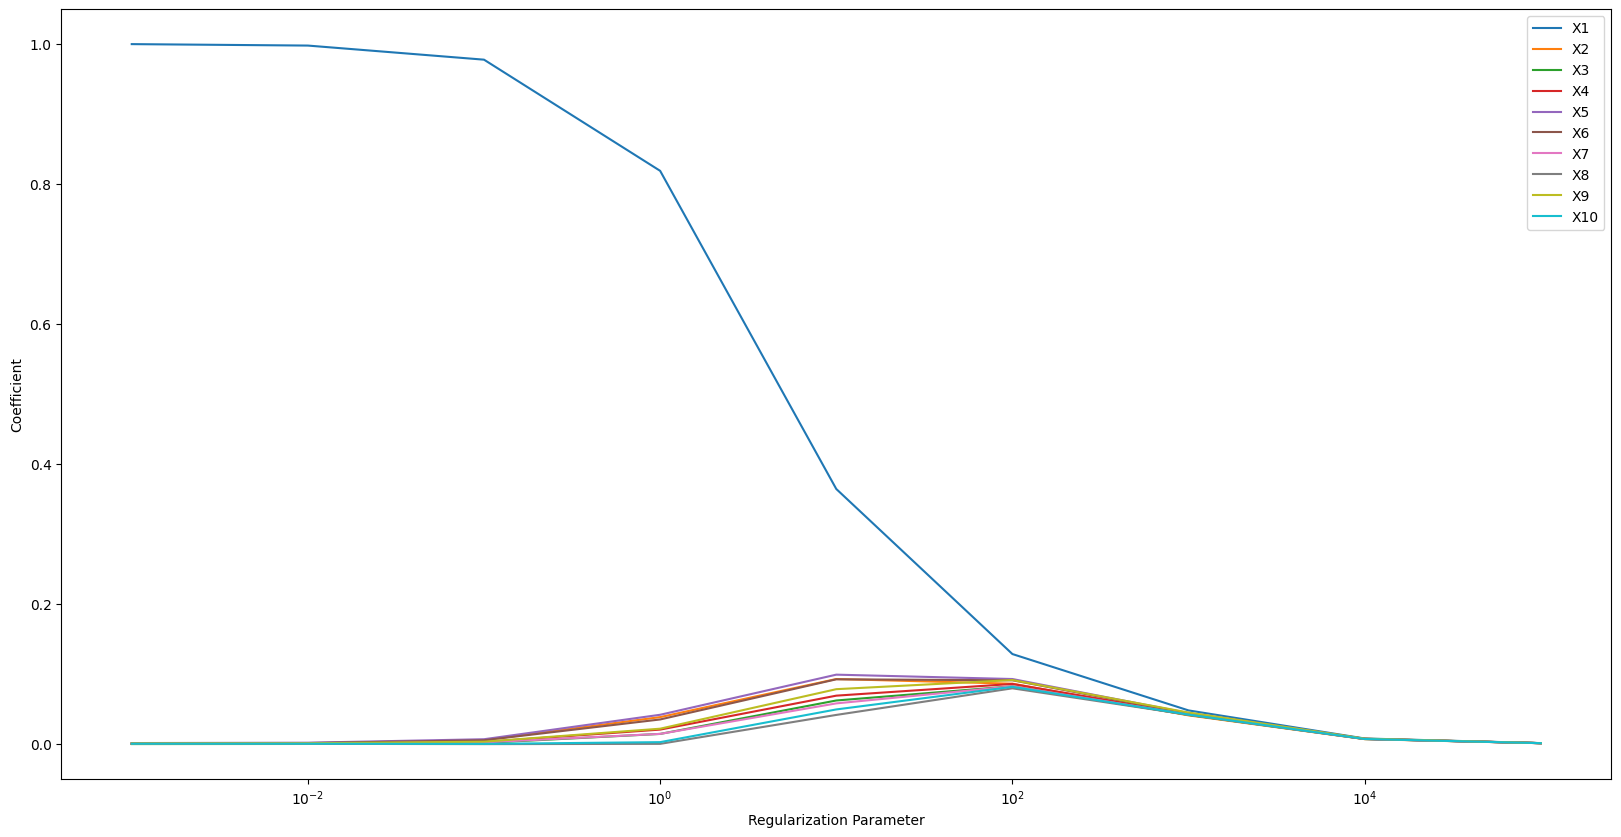

In [123]:
coefs = []
lambdas = [.001, .01, .1, 1, 10, 100, 1000,10000,100000]
for i in lambdas:
    model = Ridge(alpha=i)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)    
    
plt.figure(figsize=(20, 10))
plt.plot(lambdas, coefs)
plt.xscale('log')
plt.xlabel('Regularization Parameter')
plt.ylabel('Coefficient')
plt.legend([f'X{i}' for i in range(1,11)])

In [124]:
params = {'alpha': lambdas}
grid = GridSearchCV(Ridge(), params, cv=5)
grid.fit(X_train, y_train)
best_alpha_ridge = grid.best_params_['alpha']
print("Ridge:", best_alpha_ridge)
model = Ridge(alpha=best_alpha_ridge)
model.fit(X_train, y_train)
ridge_y_pred = model.predict(X_test)
ridge_mse_error = mean_squared_error(y_test, ridge_y_pred)
print("Ridge MSE:", ridge_mse_error)

Ridge: 0.001
Ridge MSE: 9.51406992495169e-07


###  Ridge Regularization has a lower test MSE and also the value of best alpha is 0.001 for both Lasso and Ridge. The value of best alpha is same in both Ridge and Lasso Regression

## b.) Using best parameters

In [127]:
mean = np.ones(10) * 10
cov = np.ones((10, 10)) * 0.95
np.fill_diagonal(cov, 1)
lasso_coefficients = np.zeros((10, 50))
ridge_coefficients = np.zeros((10, 50))

for i in range(50):
    X = np.random.multivariate_normal(mean, cov, size=100)
    eps = np.random.normal(0, 0.001, size=100)
    y = X[:,0] + eps
    model_lasso = Lasso(alpha=best_alpha_lasso)
    model_lasso.fit(X, y)
    lasso_coefficients[:, i] = model_lasso.coef_
    model_ridge = Ridge(alpha=best_alpha_ridge)
    model_ridge.fit(X, y)
    ridge_coefficients[:, i] = model_ridge.coef_

lasso_std_dev = np.std(lasso_coefficients, axis=1)
print("Variability in Lasso Coefficients")
for i in range(10):
    print(lasso_std_dev[i])

Variability in Lasso Coefficients
0.0001712603608186237
8.444956899912107e-06
6.342247723820824e-06
1.641174525554461e-05
1.6996826221177573e-05
2.3550283257632986e-05
8.266557437632163e-06
1.8136222699625817e-05
1.4969022044232352e-06
1.355294654464206e-06


In [128]:
ridge_std_dev = np.std(ridge_coefficients, axis=1)
print("Variability in Ridge Coefficients")
for i in range(10):
    print(ridge_std_dev[i])

Variability in Ridge Coefficients
0.00041226332222959805
0.0003935383895735373
0.000408569917132442
0.0003592786908880156
0.000457837367257573
0.00041529548784625193
0.00044723542395259556
0.00042429265113928675
0.00042991458202452806
0.0004272506085090653


### It is seen that Lasso has lesser variability as compared to Ridge because it pushes the coefficients to 0 which introduces sparsity.

### c) Elastic Net

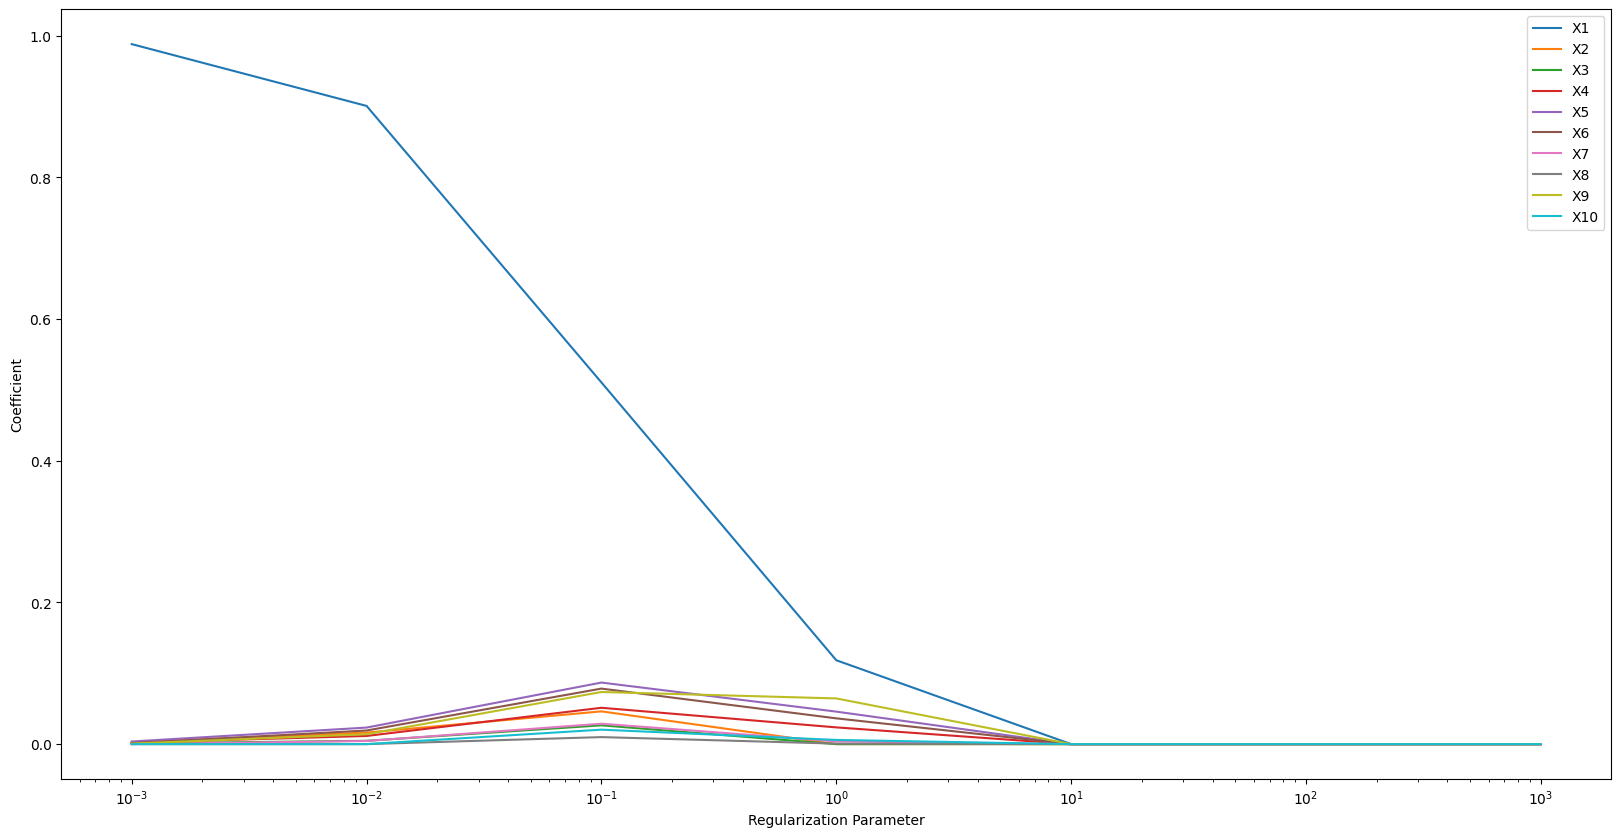

In [129]:
lambdas = [.001, .01, .1, 1, 10, 100, 1000]
coefs = []
for i in lambdas:
    en = ElasticNet(alpha=i, l1_ratio=0.5)
    en.fit(X_train, y_train)
    coefs.append(en.coef_)
plt.figure(figsize=(20, 10))
plt.plot(lambdas, coefs)
plt.xscale('log')
plt.xlabel('Regularization Parameter')
plt.ylabel('Coefficient')
plt.legend([f'X{i}' for i in range(1,11)])
plt.show()

In [130]:
kfold = KFold(n_splits=5, shuffle=True)
elastic_model = ElasticNetCV(l1_ratio=0.5, cv=kfold)
elastic_model.fit(X_train, y_train)
best_alpha = elastic_model.alpha_
alphas = elastic_model.alphas_
print('Elastic Parameter:', best_alpha)

Elastic Parameter: 0.0015759408162172098


In [135]:
best_model = ElasticNet(alpha=best_alpha, l1_ratio=0.5)
best_model.fit(X_train, y_train)
y_pred_elastic = best_model.predict(X_test)
elastic_mse_error = mean_squared_error(y_test, y_pred_elastic)
print('LASSO MSE :', lasso_mse_error)
print('Ridge MSE :', ridge_mse_error)
print('Elastic Net MSE :', elastic_mse_error)

LASSO MSE : 3.3200043106900986e-06
Ridge MSE : 9.51406992495169e-07
Elastic Net MSE : 2.8484574032183797e-05


### Using best parameters

In [136]:
mean = np.ones(10) * 10
cov = np.ones((10, 10)) * 0.95
np.fill_diagonal(cov, 1)
elastic_coefficients = np.zeros((10, 50))
for i in range(50):
    X = np.random.multivariate_normal(mean, cov, size=100)
    eps = np.random.normal(loc=0, scale=0.001, size=100)
    y = X[:,0] + eps
    best_model = ElasticNet(alpha=best_alpha)
    best_model.fit(X, y)
    elastic_coefficients[:, i] = best_model.coef_
elastic_std_dev = np.std(elastic_coefficients, axis=1)

print("Variability in Elastic Coefficients")
for i in range(10):
    print(elastic_std_dev[i])

Variability in Elastic Coefficients
0.0021509970309619474
0.0017725659467150688
0.0015581879806359088
0.001560629162898148
0.0012950651048992566
0.0013038720885854634
0.0014048144167926472
0.0012585246181121615
0.0007963262213410153
0.0009342572960858609


### Elastic net has both components of of lasso and ridge and hence has highest test error compared to Ridge and Lasso as there are two components being added to the loss. Based on the results, Ridge, regression is the obvious choice for this dataset as it has the lowest test error.

## Problem 3

In [137]:
data = pd.read_csv('framingham.csv')
data.replace(to_replace = -9, value = 0, inplace = True)
outcome = 'death'
covariates = list(data.columns)
covariates.remove('death')

## a.) Logistic with L1

In [138]:
def logistic_l1(data, outcome, covariates):
    X_train = data[covariates]
    y_train = data[outcome]
    params = {
    'penalty' : ['l1'], 
    'C'       : [1000,100,10,0.1,0.01, 0.001,0.0001],
    'solver'  : ['liblinear']}
    grid = GridSearchCV(LogisticRegression(), params, scoring = 'accuracy',cv=10)
    grid.fit(X_train, y_train)
    return grid

In [139]:
grid = logistic_l1(data, outcome, covariates)
grid.best_params_

{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

In [140]:
grid.best_estimator_.coef_

array([[ 1.16608608e-01, -5.80397707e-01,  5.66854358e-02,
        -3.71649637e-02,  2.66144052e-02,  1.25361777e-03,
         9.40287310e-04, -7.40354280e-04, -1.20335103e-03,
         6.85205010e-04,  4.97359713e-04]])

In [141]:
grid.best_score_

0.811310346814149

### The accuracy in case of L1 is 0.81 and the value of regularization parameter is chosen as 1000 which means it is penalizing the coefficients significantly to avoid overfitting. In terms of interpreting the coefficients, the cofficient of age is positive and high which means that increase in age increases the log odds of death. The negative coefficients impley that increase in thos predictors decrease the log odds of death.

## b.) Logistic with L2

In [142]:
def logistic_l2(data, outcome, covariates):
    X_train = data[covariates]
    y_train = data[outcome]
    params = {
    'penalty' : ['l2'], 
    'C'       : [10000,1000,100,10,0.1,0.01, 0.001,0.0001],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
    grid = GridSearchCV(LogisticRegression(), params, scoring = 'accuracy',cv=10)
    grid.fit(X_train, y_train)
    return grid

In [143]:
grid = logistic_l2(data, outcome, covariates)
grid.best_params_

{'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}

In [144]:
grid.best_score_

0.8116920152091254

In [145]:
grid.best_estimator_.coef_

array([[ 1.16554803e-01, -5.80789167e-01,  5.96207387e-02,
        -4.01445237e-02,  2.66206708e-02,  1.24723164e-03,
         9.40551994e-04, -7.41299313e-04, -1.20684290e-03,
         6.91002225e-04,  4.98800088e-04]])

In [146]:
covariates

['age',
 'sex',
 'BMI0',
 'BMI10',
 'cigarettes',
 'chol0',
 'chol2',
 'chol4',
 'chol6',
 'chol8',
 'chol10']

 ### The accuracy in case of L2 is 0.81 and the value of regularization parameter is chosen as 10000 which means it is penalizing the coefficients significantly to avoid overfitting. In terms of interpreting the coefficients, the cofficient of age is positive and highest which means that increase in age increases the log odds of death. The negative coefficients impley that increase in thos predictors decrease the log odds of death.

## c.) Logistic without Regularization 

In [147]:
def logistic(dataset, outcome_var, covariate_list):
    X_train = data[covariates]
    y_train = data[outcome]
    params = {
    'penalty' : ['none'],
    'C'       : [1000,100,10,0.1,0.01, 0.001,0.0001]}
    grid = GridSearchCV(LogisticRegression(), params, scoring = 'accuracy',cv=10)
    grid.fit(X_train, y_train)
    return grid

In [148]:
grid = logistic(data, outcome, covariates)
grid.best_params_

{'C': 1000, 'penalty': 'none'}

In [149]:
grid.best_score_

0.7968818412259477

In [150]:
grid.best_estimator_.coef_

array([[ 7.57815297e-02, -9.37343750e-01,  3.59630377e-02,
        -1.28937981e-01,  5.01303421e-03, -1.86799941e-03,
         1.08006482e-03, -1.83139560e-03, -7.29342986e-04,
         4.05725281e-04,  3.71730620e-05]])

### L2 Regularization has the smallest coefficients as compared to L1 and no regularization because it penalizes the errors quadratically. The difference is very minimal, however this difference can be bigger for a different data set. Overall, regularization is recommened as this helps in reducing overfitting and hence the model generalizes well over unseen data. 

### The prediction accuracy is similar for L1 and L2 in the range of .81. The plain logistic regression model has an accuracy of .79. This again shows that the regularization helps in reducing overfitting and the model generalizes better